# Library Imports

In [ ]:
# https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow

# library imports
import tensorflow 
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

# Data analysis tools
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# model editing library
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Warning Lib
import warnings


# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/My Drive/

data_dir = '/content/gdrive/My Drive/Rivers V2/Datasets/Original Unmodified Dataset/'

Mounted at /content/gdrive
/content/gdrive/My Drive


# Software versions

In [ ]:
print("Tensorflow-version:", tensorflow.__version__)
print("Pandas Version:", pd.__version__)
print("NumPY Version:", np.__version__)
print("Keras Version:", keras.__version__)
print("CV2 Version:", cv2.__version__)
print("Seaborn Version:", sns.__version__)
!python --version

Tensorflow-version: 2.7.0


# Create model top layers and configure fully-connected layer


In [ ]:
# https://github.com/experiencor/keras-yolo2/issues/167
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/api/applications/densenet/

# Get and Install Model weights, set top, and image input size
model_d=DenseNet201(weights='imagenet',include_top=False, input_shape=(100, 100, 3)) 

x=model_d.output

# add layers
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

# Fully-connected layer
preds=Dense(6,activation='softmax')(x) 

74850304/74836368 [==============================] - 1s 0us/step


# Standard Model summary

In [ ]:
# Raw Model
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

# Trasnfer Learning

In [ ]:
# Set all layers apart from the last 8 to not be trainable
for layer in model.layers[:-8]:
    layer.trainable=False
    
# Set last 8 layers to trainable    
for layer in model.layers[-8:]:
    layer.trainable=True

# New Model

In [ ]:
# Display new model summary
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

# Dataset Preparation: Sizing, Labels, and Arrays

In [ ]:
# Create Dataset and label array
data=[]
labels=[]

# Set rand Num Gen
random.seed(42)

# Image waste directory
imagePaths = sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Original Unmodified Dataset/")))

# SHuffle directory
random.shuffle(imagePaths)

# Print classes
print(imagePaths)

# Resize and organise images
for img in imagePaths:
    path=sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Original Unmodified Dataset/"+img)))
    for i in path:
        image = cv2.imread("/content/gdrive/My Drive/Rivers V2/Datasets/Original Unmodified Dataset/"+img+'/'+i)
        image = cv2.resize(image, (100,100))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']


In [ ]:
# Use Numpy for floating point array on wastdata array
data = np.array(data, dtype="float32") / 255.0

# Labels in numpy array
labels = np.array(labels)

# Learn one binary classifer per waste classifer
mlb = LabelBinarizer()

# Implement on labels
labels = mlb.fit_transform(labels)

# Print binary labels
print(labels[0])

[0 0 0 1 0 0]


In [ ]:
# 60/40 train/test split
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)

# print train/test split
print(xtrain.shape, xtest.shape)

(960, 100, 100, 3) (640, 100, 100, 3)


In [ ]:
# Learning rate and callback
jac = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

# Save best models
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)


# train and test model
history = model.fit(xtrain, ytrain, batch_size=8,
               steps_per_epoch=xtrain.shape[0] //8,
               epochs=30,
               verbose=2,
               callbacks=[jac, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.72657, saving model to model.h5
120/120 - 103s - loss: 1.8496 - accuracy: 0.4427 - val_loss: 0.7266 - val_accuracy: 0.7510 - lr: 0.0010 - 103s/epoch - 861ms/step
Epoch 2/30

Epoch 00002: val_loss improved from 0.72657 to 0.49107, saving model to model.h5
120/120 - 86s - loss: 1.1411 - accuracy: 0.6281 - val_loss: 0.4911 - val_accuracy: 0.8354 - lr: 0.0010 - 86s/epoch - 717ms/step
Epoch 3/30

Epoch 00003: val_loss improved from 0.49107 to 0.33341, saving model to model.h5
120/120 - 85s - loss: 0.9297 - accuracy: 0.6792 - val_loss: 0.3334 - val_accuracy: 0.8667 - lr: 0.0010 - 85s/epoch - 712ms/step
Epoch 4/30

Epoch 00004: val_loss improved from 0.33341 to 0.30482, saving model to model.h5
120/120 - 81s - loss: 0.8761 - accuracy: 0.7094 - val_loss: 0.3048 - val_accuracy: 0.8875 - lr: 0.0010 - 81s/epoch - 678ms/step
Epoch 5/30

Epoch 00005: val_loss improved from 0.30482 to 0.18916, saving model to model.h5
120/120 - 82s - loss: 0.7

In [ ]:
# Ana;ysis of model results
ypred = model.predict(xtest)

# Variables
total = 0
accurate = 0
accurateindex = []
wrongindex = []

# correct vs incorrect
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1

# Display information
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 640 	accurately-predicted-data: 468 	 wrongly-predicted-data:  172
Accuracy: 73.125 %


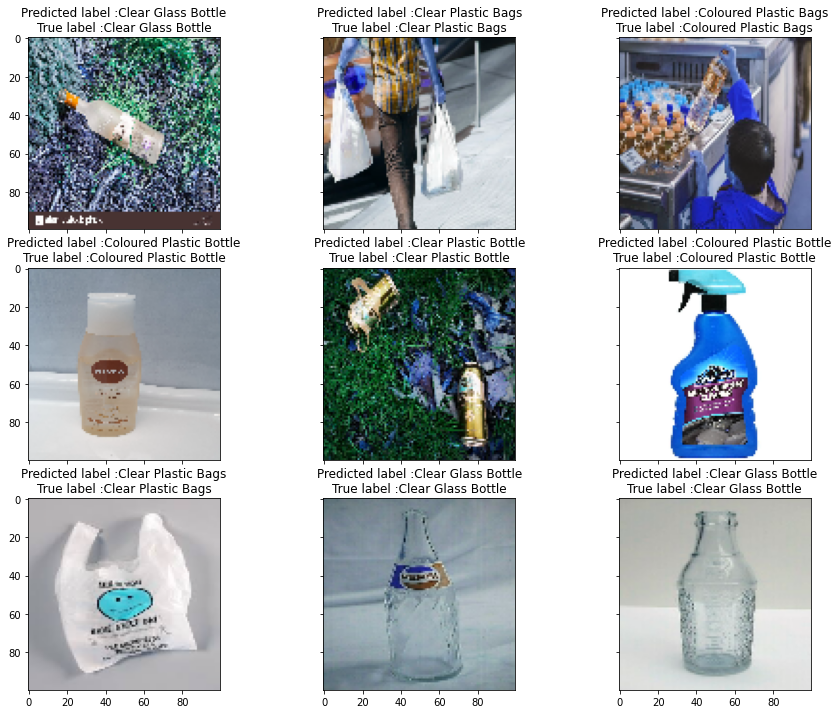

In [ ]:
label=['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

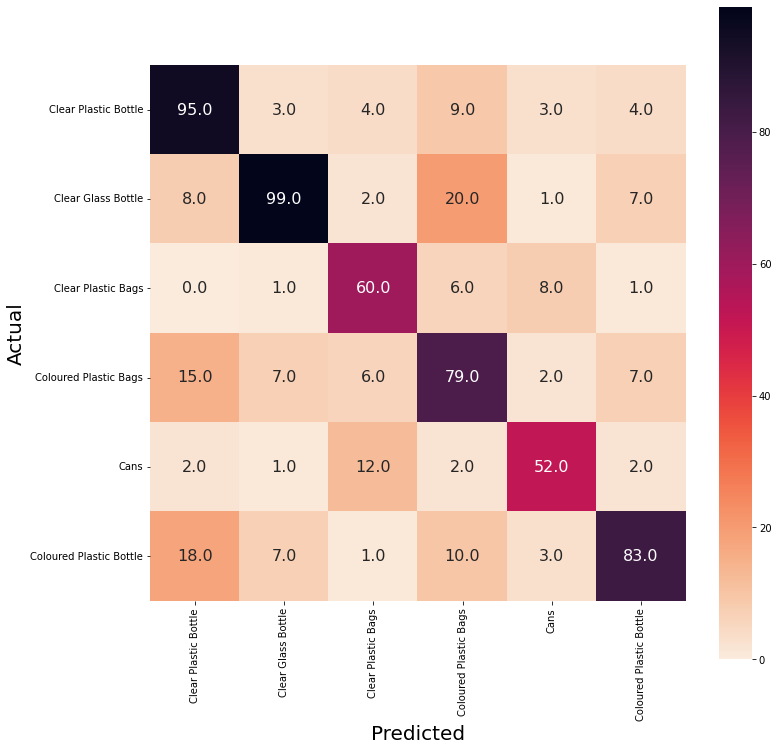

In [ ]:
# Confusion Matrix
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [ ]:
# Metrics analysis
from sklearn.metrics import classification_report, log_loss, accuracy_score

y_pred=model.predict(xtest)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(ytest,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.69      0.81      0.74       118
           1       0.84      0.72      0.78       137
           2       0.71      0.79      0.75        76
           3       0.63      0.68      0.65       116
           4       0.75      0.73      0.74        71
           5       0.80      0.68      0.73       122

    accuracy                           0.73       640
   macro avg       0.74      0.74      0.73       640
weighted avg       0.74      0.73      0.73       640



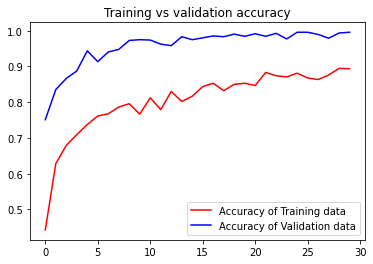

<Figure size 432x288 with 0 Axes>

In [ ]:
# Graphical Results of training and validation accuracy
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

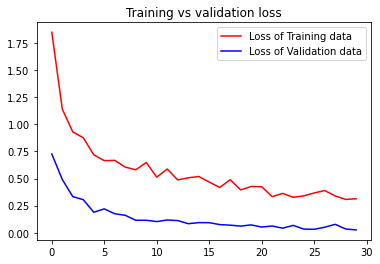

<Figure size 432x288 with 0 Axes>

In [ ]:
# Graphical Results of training and validation loss
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()